In [1]:
%%capture
%run "./3-User-Experience-Analysis.ipynb"

In [2]:
display(user_experiance.head())
display(user_engagment.head())

,MSISDN/Number,avg_RTT_ms,avg_TCPr_bytes,avg_tp_kbps,clusters_by_experiance
0,33601001722.0,46.00,21777860.54,38.00,0
1,33601001754.0,31.00,21777860.54,49.50,0
2,33601002511.0,50.00,21777860.54,48.50,0
3,33601007832.0,84.00,772117.81,124.00,0
4,33601008617.0,119.00,31148692.54,28422.00,0


,MSISDN,session_freq,session_duration,session_data_volume,clusters_by_engagement
0,33614892860.0,17,9966905758.00,16341524035.00,1
1,33626320676.0,18,8791936680.00,15996644092.00,1
2,33625779332.0,17,18553763486.00,14701273330.00,1
3,33675877202.0,15,4865953827.00,14556184322.00,2
4,33659725664.0,16,4035436251.00,13888413360.00,2


In [3]:
user_engagment.groupby('clusters_by_engagement').sum()

,session_freq,session_duration,session_data_volume
clusters_by_engagement,,,
0,105294,8031876008751.00,104599314454748.00
1,5145,1431625816443.00,2549745395204.00
2,38067,6142191870908.00,29021418483542.00


Least enaged cluster is `1`

In [4]:
least_engaged_center = engagement_model.cluster_centers_[1]
# least_engaged_center

In [5]:
user_experiance.groupby('clusters_by_experiance').describe()


avg_RTT_ms                                                 avg_TCPr_bytes                                                                                   avg_tp_kbps                                                             
                            count   mean    std   min   25%   50%    75%      max          count        mean          std    min         25%         50%         75%           max       count     mean      std    min     25%      50%      75%       max
clusters_by_experiance                                                                                                                                                                                                                                     
0                       103351.00 156.05 672.16  0.00 48.00 60.00 118.00 96924.00      103351.00 31291900.44 155858962.08 466.00 14964291.50 21777860.54 21822200.04 8354209105.00   103351.00 10231.44 21301.76   0.00   48.00   116.00 12326.75 451111.00
1                         1198.00  59.32  44.67 21.00 39.00 48.00  61.00   548.00        1198.00     8802.62     10014.48  97.00     2752.00     5767.50    11281.00     159132.00     1198.00 20886.60 16558.91 660.50 9342.62 16595.00 27022.25 191435.50
2                         1922.00  78.06 115.62 20.00 44.00 55.00  78.00  3940.00        1922.00    43293.30     47595.91 182.00    13464.25    28930.50    56035.75     631034.00     1922.00 18552.91 17202.04  84.50 6829.00 14124.25 24626.12 161043.50

I am choosing cluster `0` as the cluster with the worst experiance. The RTT and TCP retransmission volums are very high than the other two. There are a lot more users in that cluster. They also have the lowest maan TP. 

**note to self: Find a better (more definate) way to make these decision.**

In [6]:
worst_exp_center = experiance_model.cluster_centers_[0]

## Get the euclidian distance between the chosen centers and each point

In [7]:
from sklearn.metrics.pairwise import euclidean_distances
def get_score(features: np.array, center: np.array) -> np.array:
    scores = euclidean_distances(features, center.reshape(1, -1))
    return scores

In [8]:
norm_user_engagment.head()

,session_freq,session_duration,session_data_volume
0,0.00,0.52,0.85
1,0.00,0.48,0.88
2,0.00,0.78,0.62
3,0.00,0.32,0.95
4,0.00,0.28,0.96


The session_freq seems zero. But it's not. It being truncated when printing because of a pandas setting I am using. 

In [9]:
engagement_features = norm_user_engagment.to_numpy()
print(engagement_features[:2])
experiance_features = norm_user_experiance.to_numpy()
print(experiance_features[:2])

[[8.88137699e-10 5.20704985e-01 8.53736680e-01]
 [9.86111497e-10 4.81657213e-01 8.76359703e-01]]
[[2.11223687e-06 1.00000000e+00 1.74489133e-06]
 [1.42346398e-06 1.00000000e+00 2.27295055e-06]]


In [10]:
engagement_scores = get_score(engagement_features, least_engaged_center)
print(engagement_scores.shape)
experiance_scores = get_score(experiance_features, worst_exp_center)
print(experiance_scores.shape)



(106471, 1)
(106471, 1)


In [11]:
print(experiance_features.shape)

(106471, 3)


In [12]:
user_engagment['engaement_score'] = engagement_scores
user_experiance['experiance_score'] = experiance_scores


In [13]:
satisfaction_score = np.mean(np.array([engagement_scores, experiance_scores]), axis=0)
satisfaction_score

array([[0.01602863],
       [0.01606504],
       [0.18889281],
       ...,
       [0.18528583],
       [0.19637926],
       [0.26637801]])

In [14]:
scored_user_data = pd.DataFrame()

for col in user_experiance.columns[:-2]:
    scored_user_data[col] = user_experiance[col].values
for col in user_engagment.columns[1:-2]:
    scored_user_data[col] = user_engagment[col].values
scored_user_data['satisfaction_score'] = satisfaction_score
scored_user_data.head()

,MSISDN/Number,avg_RTT_ms,avg_TCPr_bytes,avg_tp_kbps,session_freq,session_duration,session_data_volume,satisfaction_score
0,33601001722.0,46.00,21777860.54,38.00,17,9966905758.00,16341524035.00,0.02
1,33601001754.0,31.00,21777860.54,49.50,18,8791936680.00,15996644092.00,0.02
2,33601002511.0,50.00,21777860.54,48.50,17,18553763486.00,14701273330.00,0.19
3,33601007832.0,84.00,772117.81,124.00,15,4865953827.00,14556184322.00,0.10
4,33601008617.0,119.00,31148692.54,28422.00,16,4035436251.00,13888413360.00,0.12


In [15]:
scored_user_data['satisfaction_score'].describe()

count   106471.00
mean         0.21
std          0.08
min          0.01
25%          0.19
50%          0.21
75%          0.24
max          0.95
Name: satisfaction_score, dtype: float64

looking at the percentiles, most users don't seem to be satisfied by the services they are getting.

<AxesSubplot:title={'center':'Histogram of the user satisfaction score'}, ylabel='Frequency'>

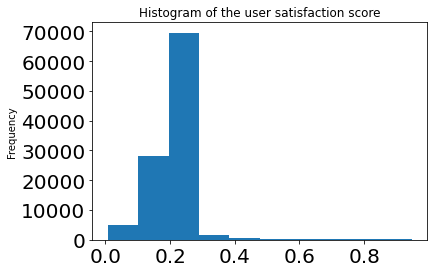

In [16]:
scored_user_data['satisfaction_score'].plot.hist(title="Histogram of the user satisfaction score", fontsize=20)
# plotter.plot_count(scored_user_data, 'satisfaction_score')

### top 10 satisfied customer 

In [17]:
top_satisfied_user = analyzer.get_top_ten(scored_user_data, 'satisfaction_score')
top_satisfied_user

,MSISDN/Number,avg_RTT_ms,avg_TCPr_bytes,avg_tp_kbps,session_freq,session_duration,session_data_volume,satisfaction_score
0,33607833304.0,32.00,143.00,8426.50,4,66595562.00,3785411332.00,0.95
1,33679366089.0,39.00,179.00,17534.00,1,24480059.00,797352274.00,0.94
2,33661931340.0,28.00,2774.00,74036.00,1,28087571.00,1171921249.00,0.94
3,33698217663.0,57.00,425.00,10876.00,1,16782322.00,709717038.00,0.94
4,33637975112.0,37.00,2229.00,79960.00,2,64677952.00,1790294382.00,0.94
5,33665472384.0,32.00,214.00,11076.00,1,46652234.00,998470326.00,0.93
6,33699549700.0,66.00,922.00,31179.50,1,25512661.00,645272791.00,0.93
7,33650110160.0,52.00,1994.00,36316.50,2,40795705.00,1603480117.00,0.93
8,33688395982.0,48.00,946.00,17386.50,1,20232961.00,738093691.00,0.93
9,33677187954.0,43.00,804.00,21834.00,1,33052117.00,810946492.00,0.93


In [18]:
top_satisfied_user[['MSISDN/Number', 'satisfaction_score']]

,MSISDN/Number,satisfaction_score
0,33607833304.0,0.95
1,33679366089.0,0.94
2,33661931340.0,0.94
3,33698217663.0,0.94
4,33637975112.0,0.94
5,33665472384.0,0.93
6,33699549700.0,0.93
7,33650110160.0,0.93
8,33688395982.0,0.93
9,33677187954.0,0.93


# Regression model

Following this as a refresher [blog](https://www.analyticsvidhya.com/blog/2021/05/multiple-linear-regression-using-python-and-scikit-learn/) and [this](https://www.pluralsight.com/guides/non-linear-regression-trees-scikit-learn) one from pluralsight

In [19]:
x_features = scored_user_data.iloc[:, 1:-1]
x_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106471 entries, 0 to 106470
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   avg_RTT_ms           106471 non-null  float64
 1   avg_TCPr_bytes       106471 non-null  float64
 2   avg_tp_kbps          106471 non-null  float64
 3   session_freq         106471 non-null  int64  
 4   session_duration     106471 non-null  float64
 5   session_data_volume  106471 non-null  float64
dtypes: float64(5), int64(1)
memory usage: 4.9 MB


In [20]:
Y = scored_user_data.iloc[:, -1]
Y[:3]

0   0.95
1   0.94
2   0.94
Name: satisfaction_score, dtype: float64

The data is sorted by the score, so we need to shuffle

In [21]:
from sklearn.model_selection import train_test_split


In [22]:
x_train, x_test, y_train, y_test = train_test_split(x_features, Y, test_size = 0.2, random_state = 777)


In [23]:
y_train

27112    0.24
27509    0.23
45507    0.22
32194    0.23
92811    0.15
         ... 
102321   0.09
106071   0.02
52134    0.22
81467    0.18
63591    0.21
Name: satisfaction_score, Length: 85176, dtype: float64

In [34]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.tree import DecisionTreeRegressor

In [28]:
regressor = Pipeline([
        # ('Normalizer', Normalizer()),
        # ('MinMaxScaler', MinMaxScaler()),
        ('StandardScaler', StandardScaler()),
        ('model', DecisionTreeRegressor(max_depth=8, random_state=3))
    ]
)

In [36]:
regressor.fit(x_train, y_train)
train_pred = regressor.predict(x_train)
print(f"training r2_score: {r2_score(y_train, train_pred)}")
print(f"training sqrt_mse: {np.sqrt(mse(y_train, train_pred))}")

training r2_score: 0.9539543914993333
training mse: 0.017442098609796057


In [37]:
test_preds = regressor.predict(x_test)
print(f"test r2_score: {r2_score(y_test, test_preds)}")
print(f"test sqrt_mse: {np.sqrt(mse(y_test, test_preds))}")

test r2_score: 0.933976906799864
test sqrt_mse: 0.02078694584333897


Since the model is doing good on the test data, I belive it is good enough.

In [38]:
from joblib import dump

dump(regressor, '../models/regression_tree.joblib')  

['../models/regression_tree.joblib']

# K-means for engagement & experience scores

In [76]:
eng_exp_scores = StandardScaler().fit_transform(np.hstack([engagement_scores, experiance_scores]))
eng_exp_scores.shape

(106471, 2)

In [77]:
eng_exp_kmeans = KMeans(n_clusters=2,
                init='k-means++',
                max_iter=300,
                n_init=10,
                random_state=10)

eng_exp_kmeans = eng_exp_kmeans.fit(eng_exp_scores)
dump(eng_exp_kmeans, "../models/eng_exp_clustering_model.joblib")
print("model saved")

scored_user_data['exp_eng_clusters'] = eng_exp_kmeans.predict(eng_exp_scores)
scored_user_data['exp_eng_clusters'].unique()

model saved


array([0, 1], dtype=int32)

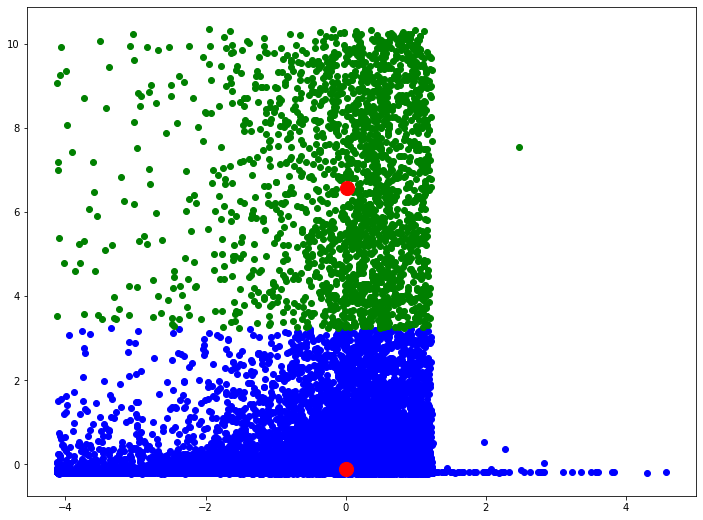

In [78]:
ax = plt.figure(figsize=(12, 9))


c0 = scored_user_data[scored_user_data['exp_eng_clusters']==0].index.values
c1 = scored_user_data[scored_user_data['exp_eng_clusters']==1].index.values

plt.scatter(eng_exp_scores[c0, 0], 
            eng_exp_scores[c0, 1],
           color='blue')
plt.scatter(eng_exp_scores[c1, 0], 
            eng_exp_scores[c1, 1],
           color='green')


# Plot the clusters 
plt.scatter(eng_exp_kmeans.cluster_centers_[:, 0], 
            eng_exp_kmeans.cluster_centers_[:, 1], 
            s=200,                             # Set centroid size
            c='red')                           # Set centroid color
plt.show()

## Aggregate per cluster satisfaction and experience score

In [79]:
scored_user_data['engagement_score'] = engagement_scores
scored_user_data['experiance_score'] = experiance_scores
score_columns = [col for col in scored_user_data.columns if col.endswith('_score')]
score_columns

['satisfaction_score', 'engagement_score', 'experiance_score']

In [80]:
scored_user_data.groupby('exp_eng_clusters')[score_columns].mean()

,satisfaction_score,engagement_score,experiance_score
exp_eng_clusters,,,
0,0.21,0.39,0.01
1,0.21,0.40,0.90


# Export the final table

In [81]:
scored_user_data.head()

,MSISDN/Number,avg_RTT_ms,avg_TCPr_bytes,avg_tp_kbps,session_freq,session_duration,session_data_volume,satisfaction_score,exp_eng_clusters,engagement_score,experiance_score
0,33607833304.0,32.00,143.00,8426.50,4,66595562.00,3785411332.00,0.95,0,0.03,0.01
1,33679366089.0,39.00,179.00,17534.00,1,24480059.00,797352274.00,0.94,0,0.03,0.01
2,33661931340.0,28.00,2774.00,74036.00,1,28087571.00,1171921249.00,0.94,0,0.37,0.01
3,33698217663.0,57.00,425.00,10876.00,1,16782322.00,709717038.00,0.94,0,0.20,0.01
4,33637975112.0,37.00,2229.00,79960.00,2,64677952.00,1790294382.00,0.94,0,0.24,0.01


In [83]:
final_data = scored_user_data[['MSISDN/Number', *score_columns]]
final_data.head()

,MSISDN/Number,satisfaction_score,engagement_score,experiance_score
0,33607833304.0,0.95,0.03,0.01
1,33679366089.0,0.94,0.03,0.01
2,33661931340.0,0.94,0.37,0.01
3,33698217663.0,0.94,0.20,0.01
4,33637975112.0,0.94,0.24,0.01


In [84]:
final_data.to_csv('../data/user_data_with_score.csv')